In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

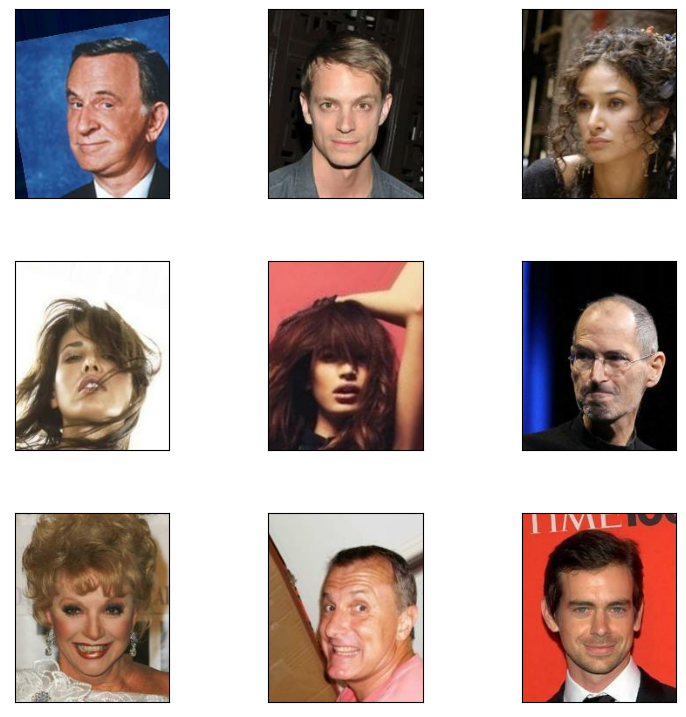

In [2]:
ds_train, ds_info = tfds.load('celeb_a', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_train, ds_info)

In [3]:
batch_size = 128
image_shape = (64, 64, 3)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image

ds_train = ds_train.map(preprocess).shuffle(ds_info.splits['train'].num_examples).batch(batch_size, drop_remainder=True).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

1272


In [4]:
class WGAN_GP():
    def __init__(self, input_shape):
        self.z_dim = 128
        self.input_shape = input_shape
        
        self.loss_critic = {}
        self.loss_gp = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False
        
        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)
        
        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):
        w_loss = -tf.reduce_mean(y_true*y_pred)
        return w_loss
    
    def build_generator(self):
        DIM = 128
        model = tf.keras.Sequential(name='Generator')
        
        model.add(layers.Input(shape=[self.z_dim]))
        
        model.add(layers.Dense(4*4*8*DIM))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,8*DIM)))
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(4*DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        
        return model
    
    def build_critic(self):
        
        DIM = 128
        model = tf.keras.Sequential(name='critics')
        
        model.add(layers.Input(shape=self.input_shape))
        
        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(8*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        
        return model
    
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1, len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss-1))
        loss = self.penalty_const*loss
        return loss
    
    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_lables = -tf.ones(batch_size)
        
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = tf.generator.predict(g_input)
        
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_lables, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)
            
            # gradient penalty
            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
            
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))
            
        return loss_fake, loss_real, gradient_penalty
    
    def train(self, data_generator, batch_size, steps, interval=100):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            self.loss_gp[i] = gradient_penalty
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
            if i%interval == 0:
                msg = 'Step {}: g_loss{:.4f} critic_loss {:.4f} critic fake {:.4f} critic_real {:.4f} penalty {.4f}'.format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                
                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()
                
    def plot_images(self, images):
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col*3.5, grid_row*3.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1] ==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gary')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off')
        plt.show()
        
    def plot_losses(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critics loss', alpha=0.7)
        ax1.set_title('Critic loss')
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title('Generator loss')
        ax3.plot(list(self.loss_gp.values()), label='Gradient penalty', alpha=0.7)
        ax3.set_title('Gradient penalty')
        plt.xlabel('Steps')
        plt.show()

In [5]:
wgan = WGAN_GP(image_shape)

In [ ]:
wgan.train(iter(ds_train), batch_size, 50000, 100)

In [ ]:
wgan.model.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
wgan.generator.summary()

In [ ]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((6, 128))
    images = wgan.generator.predict(z)
    
    grid_row = 1
    grid_col = 6
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off')
    plt.show()

In [ ]:
wgan.generator.save_weights('wgan_gp_celeb_a.weights')